## 1. Install Packages

In [ ]:
# no installations required

##2. Import Packages

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import softmax as scipy_softmax
import random
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import functools
from scipy.optimize import curve_fit
import pymc as pm
import arviz as az

##3. Create Synthetic RL Data

In [ ]:
seed = 0
np.random.seed(seed)
random.seed(seed)

bias = 0.7
trials = 200

In [ ]:
# assuming n_choices = 2
biases = [bias, 1-bias]
data = np.array(random.choices([0,1],biases,k=trials))
data

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0])

##4. Create Simple RL Model

In [ ]:
def softmax(qs, tau):
  return np.exp(qs/tau) / np.exp(qs/tau).sum()

def rescola(qt, alpha, reward):
  return qt + alpha * (reward - qt)

In [ ]:
class SimpleRL:

  def __init__(self, data: np.array):
    self.n_choices: int = 2
    self.data: np.array = data
    self.qs: np.array = np.ones((self.n_choices,))
    self.q_trace: np.array = np.ones((self.data.shape[0],self.n_choices))
    self.choice_trace: np.array = np.ones_like(data)

  def train(self, alpha, temperature):
    for i, trial in enumerate(self.data):
      # Q-values are recorded to trace
      self.q_trace[i] = self.qs
      # softmax decision function
      ps = softmax(self.qs,temperature)
      # choice made based on weighted probabilities of Q-values
      # choice = random.choices(range(self.n_choices), ps)[0]
      # deterministic action selection
      choice = np.argmax(ps)
      # choice is recorded to trace
      self.choice_trace[i] = choice
      # reward calculated
      reward = int(choice == trial) - int(choice != trial)
      # Q-values updated
      self.qs[choice] = rescola(self.qs[choice],alpha,reward)
    # Q-values trace returned
    return self.q_trace

##5. Simulate Model

In [ ]:
temperature = 100
alpha = 0.05

In [ ]:
rl_model = SimpleRL(data)
qs = rl_model.train(alpha,temperature)
choices = rl_model.choice_trace

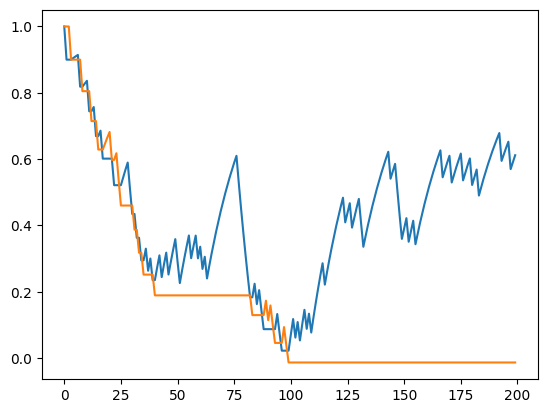

In [ ]:
# plotting q values
plt.plot(qs)

##6. Adapt to PyTensor

Do I need to fully rewreite the RL class in PyTensor? Rather than just substituting NumPy arrays for PyTensor arrays?

First let's create a working PyTensor RL step, piece by piece

###6a. Softmax

In [ ]:
# Create Softmax function
b = pt.scalar("temperature")
q_t = pt.vector("q_t")

p_t = pt.exp(q_t/b) / pt.exp(q_t/b).sum()
softmax = pytensor.function(inputs=[q_t,b],outputs=p_t)

# Test
softmax(np.array(range(2)),temperature)

array([0.26894142, 0.73105858])

###6b. Decision

In [ ]:
# Create choice function
c_t = pt.argmax(p_t)
choice = pytensor.function(inputs=[p_t],outputs=c_t)

# Test
choice(softmax(np.array(range(2)),temperature))

array(1)

###6c. Reward

In [ ]:
# Create Reward Function
d_t = pt.scalar("d_t")

r_t = pt.constant(-1.) + pt.constant(2.) * (pt.eq(c_t,d_t))
reward = pytensor.function(inputs=[d_t,c_t],outputs=r_t)

# Test
reward(1,choice(softmax(np.array(range(2)),temperature)))

array(1., dtype=float32)

###6d. Mask

*PyTensor work around*

In [ ]:
# Create mask function
n = pt.iscalar("n_choices")
m_t = pt.set_subtensor(pt.zeros((n,))[c_t], pt.constant(1.))
make_mask = pytensor.function(inputs=[c_t, n], outputs=m_t)

# Test
q = np.asarray([1,-1],dtype=np.float32)
p = softmax(q,temperature)
chose = np.int32(choice(p))
print(chose)
make_mask(chose, np.int32(2))

0


array([1., 0.])

###6e. Q-Learning Rule

In [ ]:
# Create Q-Learning function
a = pt.scalar("a")

qp1 = q_t + a * (r_t - q_t) * m_t
q_learn = pytensor.function(inputs=[q_t,a,r_t,m_t],outputs=qp1)

# Test
q_test = np.asarray([0.0,1.0])
a_test = 0.1
r_test = reward(1,choice(softmax(np.array(range(2)),temperature)))
m_test = make_mask(chose, np.int32(2))
q_learn(q_test,a_test,r_test,m_test)

array([0.1, 1. ])

###6f. All Together

In [ ]:
# parameters & variables
a = pt.scalar("a")   # alpha: learning rate
b = pt.scalar("b")   # temperature: decision temperature
n = pt.iscalar("n")  # n_choices: number of actions to choose between
q = pt.vector("q")   # q-values: learned values
d = pt.iscalar("d")  # data point: stimulus

# function building
p = pt.exp(q/b) / pt.exp(q/b).sum()                          # Probabilities = Softmax( Qs , temperature )
c = pt.argmax(p)                                             # Chosen Action = Argmax(Probabilities)
r = pt.constant(-1.) + pt.constant(2.) * (pt.eq(c,d))        # Reward Value = 1 if(Chosen Action == Data), else -1
m = pt.set_subtensor(pt.zeros((n,))[c], pt.constant(1.))     # Mask: Array shape of q-values, with a non-zero value for index=Chosen Action
qp1 = q + a * (r - q) * m                                    # Q_{t+1} = Q_{t} + alpha * (Reward - Q_{t}) * Mask

# RL single-step compilation
rl_step = pytensor.function(inputs=[a,b,n,q,d],outputs=qp1)

a_test = 0.1
b_test = 1.0
n_test = 2
q_test = np.asarray([0.0,1.0])
d_test = 1.0
rl_step(a_test,b_test,n_test,q_test,d_test)

array([0., 1.])

###6g. All Together In Loop

I wasn't able to figure out how to compile the single step function into scan, so I rewrote it out

In [ ]:
# parameters & variables
D = pt.vector("D")
Q = pt.matrix("Q")
a = pt.scalar("a")
b = pt.scalar("b")
n = pt.iscalar("n")

# scan function build
results, updates = pytensor.scan(                              # scan OPEN
    lambda d, q_tm1: q_tm1 + a * (                             # Q-Learn OPEN
        (                                                      # Error OPEN
            pt.constant(-1.) + pt.constant(2.) * (             # Reward OPEN
                pt.eq(                                         # Check OPEN
                    pt.argmax(                                 # Choose OPEN
                        pt.exp(q_tm1/b) / pt.exp(q_tm1/b).sum()# Softmax
                        ),                                     # Choose CLOSE
                    d)                                         # Check CLOSE
                )                                              # Reward CLOSE
            ) - q_tm1                                          # Error CLOSE
        ) * pt.set_subtensor(pt.zeros((n,))[                   # Index OPEN
            pt.argmax(                                         # Choose OPEN
                pt.exp(q_tm1/b) / pt.exp(q_tm1/b).sum()        # Softmax
                )                                              # Choose CLOSE
            ], pt.constant(1.))                                # Index CLOSE
         ,                                                     # Q-Learn CLOSE
          sequences=[D], outputs_info=[Q])                     # scan CLOSE

# RL Model function compilation
rl_model = pytensor.function(inputs=[D, Q, a, b, n], outputs=results)

# test values
D_test = np.ones((100), dtype=pytensor.config.floatX)
Q_test = np.zeros(shape=(100,2), dtype=pytensor.config.floatX)
a_test = 0.1
b_test = 1.0
n_test = 2

# RL Model function test
rl_model(D_test,Q_test,a_test,b_test,n_test)

In [ ]:
# parameters & variables
D = pt.vector("D")
q = pt.vector("q")
a = pt.scalar("a")
b = pt.scalar("b")
n = pt.iscalar("n")

# scan function build
results, updates = pytensor.scan(                              # scan OPEN
    lambda d, q_tm1: q_tm1 + a * (                             # Q-Learn OPEN
        (                                                      # Error OPEN
            pt.constant(-1.) + pt.constant(2.) * (             # Reward OPEN
                pt.eq(                                         # Check OPEN
                    pt.argmax(                                 # Choose OPEN
                        pt.exp(q_tm1/b) / pt.exp(q_tm1/b).sum()# Softmax
                        ),                                     # Choose CLOSE
                    d)                                         # Check CLOSE
                )                                              # Reward CLOSE
            ) - q_tm1                                          # Error CLOSE
        ) * pt.set_subtensor(pt.zeros((n,))[                   # Index OPEN
            pt.argmax(                                         # Choose OPEN
                pt.exp(q_tm1/b) / pt.exp(q_tm1/b).sum()        # Softmax
                )                                              # Choose CLOSE
            ], pt.constant(1.))                                # Index CLOSE
         ,                                                     # Q-Learn CLOSE
          sequences=[D], outputs_info=[q])                     # scan CLOSE

# RL Model function compilation
rl_model = pytensor.function(inputs=[D, q, a, b, n], outputs=results)

# test values
D_test = np.ones((200), dtype=pytensor.config.floatX)
q_test = np.zeros(shape=(2,), dtype=pytensor.config.floatX)
a_test = 0.1
b_test = 1.0
n_test = 2

# RL Model function test
rl_model(D_test,q_test,a_test,b_test,n_test)

##7. Calculate Likelihoods

In [ ]:
# Creating Ground Truth Data
a_true = 0.1
b_true = 0.8
q_true = np.zeros(shape=(2,), dtype=pytensor.config.floatX)
D_true = data
Q_true = rl_model(D_true,q_true,a_true,b_true,2)
C_true = np.asarray([np.argmax(q_t) for q_t in Q_true])
C_true

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [ ]:
# blackbox loglikelihood function for RL Model
def rl_ll(a,b,D,C):
    q = q_test
    n = 2
    Q_predict = rl_model(D,q,a,b,n)
    probabilities = scipy_softmax(Q_predict)
    selected_probabilities = probabilities[np.arange(D.shape[0]), np.int32(D)]
    log_likelihood = -np.sum(np.log(selected_probabilities))
    # return -np.sum(np.log(softmax(Q_predict)))
    return log_likelihood

rl_ll(a_test,b_test,D_test,C_true)

1121.1293512671696

In [ ]:
# Initial parameter values
a_predict = 0.
b_predict = 0.
D_true = data

# Wrapper function to pass RL model into minimize function
def rl_ll_wrapper(a,b,D,C):
  params = (a,b)
  def rl_ll_scipy(params,D,C):
    return rl_ll(params[0],params[1],D,C)
  return rl_ll_scipy

# Using SciPy'S minimize optimizer to recover ground truth parameters
minimize(rl_ll_wrapper(a_predict,b_predict,D_true,C_true),(a_predict,b_predict),args=(D_true,C_true))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1134.5328020990369
        x: [ 1.049e+00 -2.501e-08]
      nit: 8
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 2.925e-03 -1.520e-11]
            [-1.520e-11  5.457e-18]]
     nfev: 27
     njev: 9

##8. PyMC Models

Wrapping model into PyMC using pm potential

Code was taken from PyMC documentation and modified

In [ ]:
# define a pytensor Op for our likelihood function
class LogLike(pt.Op):

    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, c):
        # add inputs as class attributes
        self.likelihood = loglike
        self.D = data
        self.C = c

    def perform(self, node, inputs, outputs):
      (theta,) = inputs  # this will contain my variables
      # a, b = inputs
      outputs[0][0] = np.array(self.likelihood(theta, self.D, self.C))
        #logl = self.likelihood(self.a, self.b, self.D, self.C)
        #outputs[0][0] = np.array(logl)  # output the log-likelihood

/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/traceplot.py:217: UserWarning: A valid var_name should be provided, found {'c', 'm'} expected from {'b', 'a'}
  warnings.warn(


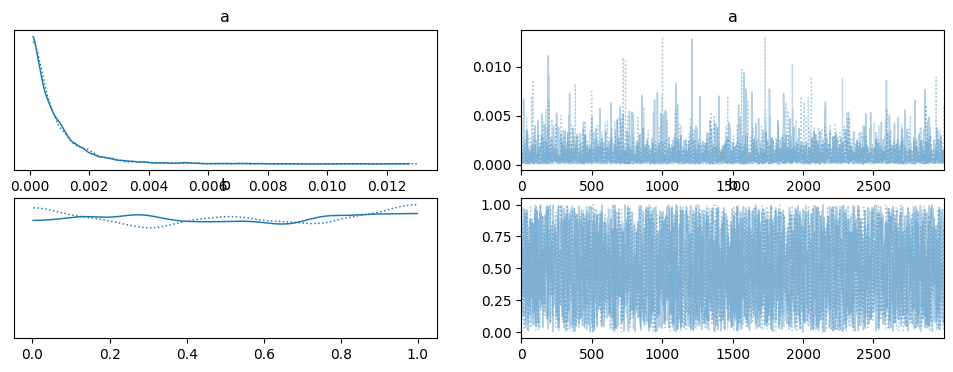

In [ ]:
# set up our data
a_true, b_true, D_true, C_true

# create our Op
rl_ll_scipy = rl_ll_wrapper(a_true, b_true, D_true, C_true)
logl = LogLike(rl_ll_scipy, D_true, C_true)

# use PyMC to sampler from log-likelihood
with pm.Model():
    # uniform priors on m and c
    a = pm.Uniform("a", lower=1e-4, upper=1e-0)
    b = pm.Uniform("b", lower=1e-4, upper=1e+0)

    # convert m and c to a tensor vector
    theta = pt.as_tensor_variable([a, b])

    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("likelihood", logl(theta))

    # Use custom number of draws to replace the HMC based defaults
    idata_mh = pm.sample(3000, tune=1000)

# plot the traces
az.plot_trace(idata_mh, lines=[("m", {}, a_true), ("c", {}, b_true)]);